In [1]:
import os
from detanet_model import *

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

# Load the dataset
dataset = torch.load(os.path.join(data_dir, 'HOPV_241pol.pt'))
print(f"Number of graphs in the dataset: {len(dataset)}")

for data in dataset:
    data.real_ee = data.real_ee
    data.imag_ee = data.imag_ee
    data.y = torch.cat([data.real_ee, data.imag_ee], dim=0)
    data.spectra = data.spectra[1:]
    data.x = data.spectra.repeat(len(data.z), 1)


ex1 = dataset[0]
print("dataset[0] :", ex1, )

Number of graphs in the dataset: 347
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', z=[68], freqs=[242], spectra=[241], real_ee=[242, 3, 3], imag_ee=[242, 3, 3], real_em=[242, 3, 3], imag_em=[242, 3, 3], real_mm=[242, 3, 3], imag_mm=[242, 3, 3], osc_pos=[40], osc_strength=[40], y=[484, 3, 3], x=[68, 241])


In [2]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(3512)
random.shuffle(dataset)
train_frac = 0.9
split_index = int(train_frac * len(dataset))

train_datasets = dataset[:split_index]
val_datasets   = dataset[split_index:]


In [4]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = model_loader.hopv241_dynamic_polarizability_model(device=device)
model.to(device)


DetaNet(
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=271, bias=False)
    (nuclare_emb): Embedding(35, 271)
    (ls): Linear(in_features=271, out_features=271, bias=True)
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=512, out_features=512, bias=True)
          (lk): Linear(in_features=512, out_features=512, bias=True)
          (lv): Linear(in_features=512, out_features=1024, bias=True)
          (la): Linear(in_features=1024, out_features=1024, bias=True)
          (lrbf): Linear(in_features=32, out_features=512, bias=False)
          (lkrbf): Linear(in_features=512, out_features=512, bias=False)
          (lvrbf): Linear(in_fe

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd          # NEW – for CSV export


def plot_polarizability_elements(data_entry, model, out_dir=".", save_csv=True):
    """
    Plot ground-truth and predicted polarizability spectra (real + imag) for one molecule
    and (optionally) dump all plotted points to CSV so the figure can be reproduced.

    """

    # ──────────────────────────────────────────────────────────────────
    # 1.  Ground-truth tensors (drop static slice)                     │
    # ──────────────────────────────────────────────────────────────────
    mol_idx   = data_entry.idx
    real_list = np.asarray(data_entry.real_ee)          # [N+1, 3, 3]
    imag_list = np.asarray(data_entry.imag_ee)          # [N+1, 3, 3]

    static_pol = real_list[0]
    real_list  = real_list[1:]
    imag_list  = imag_list[1:]
    N = real_list.shape[0]

    # ──────────────────────────────────────────────────────────────────
    # 2.  Model prediction                                              │
    # ──────────────────────────────────────────────────────────────────
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device).eval()
    with torch.no_grad():
        pol_spec = model(
            z=data_entry.z.to(device),
            pos=data_entry.pos.to(device),
            x_features=data_entry.x.to(device)
        ).cpu().numpy()                                # [N_real+N_imag, 3, 6]

    half            = pol_spec.shape[0] // 2
    pred_pol_real   = pol_spec[:half]
    pred_pol_imag   = pol_spec[half:]
    pred_pol_real  += static_pol                       # add α(0) to each real slice

    # ──────────────────────────────────────────────────────────────────
    # 3.  CSV dump (optional)                                           │
    # ──────────────────────────────────────────────────────────────────
    if save_csv:
        os.makedirs(out_dir, exist_ok=True)

        # frequencies: tensor → NumPy, drop static freq (index 0)
        freq = np.asarray(
            data_entry.freqs[1:].cpu() if torch.is_tensor(data_entry.freqs)
            else data_entry.freqs[1:], dtype=float
        )

        lbls = ["xx", "yy", "zz"]                     # we plot only diagonals
        cols = [f"{l}_{src}" for src in ("gt", "pred") for l in lbls]

        def _make_df(gt, pred):
            arr = np.stack([gt[:, i, i] for i in range(3)] +
                           [pred[:, i, i] for i in range(3)], axis=1)
            return pd.DataFrame(arr, columns=cols, index=freq)

        _make_df(real_list, pred_pol_real).to_csv(
            os.path.join(out_dir, f"polarizability_real_{mol_idx}.csv"),
            index_label="frequency_eV"
        )
        _make_df(imag_list, pred_pol_imag).to_csv(
            os.path.join(out_dir, f"polarizability_imag_{mol_idx}.csv"),
            index_label="frequency_eV"
        )

    # ──────────────────────────────────────────────────────────────────
    # 4.  Plot settings (unchanged)                                    │
    # ──────────────────────────────────────────────────────────────────
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
        "font.size": 16
    })

    pairs   = [(0, 0), (1, 1), (2, 2)]        # diagonal components
    labels  = ["xx", "yy", "zz"]
    nrows, ncols = 1, 3

    gt_kwargs      = dict(marker='o', color='royalblue', s=10, alpha=0.6)
    gt_kwargs_imag = dict(marker='o', color='orange',   s=10, alpha=0.8)
    pred_kwargs    = dict(marker='^', color='black',    s=6,  alpha=0.6)

    rmin = min(real_list.min(), pred_pol_real.min()) - 20
    rmax = max(real_list.max(), pred_pol_real.max()) + 20
    imin = min(imag_list.min(), pred_pol_imag.min()) - 20
    imax = max(imag_list.max(), pred_pol_imag.max()) + 20

    # ───────────────  Real part  ───────────────
    fig_r, axes_r = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)

    for idx, (i, j) in enumerate(pairs):
        ax = axes_r[idx]
        ax.scatter(data_entry.freqs[1:], real_list[:, i, j],  label="GT", **gt_kwargs)
        ax.scatter(data_entry.freqs[1:], pred_pol_real[:, i, j], label="Prediction", **pred_kwargs)
        ax.set_title(labels[idx])
        ax.set_ylim(rmin, rmax)
        ax.grid(True)

    fig_r.text(0.5, 0.04, "Frequency (eV)", ha="center", va="center", fontsize=22)
    fig_r.text(0.05, 0.5, "α-Real (a.u.)",  ha="center", va="center", rotation="vertical", fontsize=22)
    handles, lbls = axes_r[0].get_legend_handles_labels()
    fig_r.legend(handles, lbls, loc="upper right", bbox_to_anchor=(0.97, 0.85),
                 fontsize=22, markerscale=3.0, frameon=True, facecolor="white",
                 edgecolor="0.7", framealpha=0.8)
    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    os.makedirs(out_dir, exist_ok=True)
    fig_r.savefig(os.path.join(out_dir,
        f"polar_elements_real_{mol_idx}_{data_entry.dataset_name}.png"), dpi=300)
    plt.show(); plt.close(fig_r)

    # ───────────────  Imag part  ───────────────
    fig_i, axes_i = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)

    for idx, (i, j) in enumerate(pairs):
        ax = axes_i[idx]
        ax.scatter(data_entry.freqs[1:], imag_list[:, i, j], label="GT", **gt_kwargs_imag)
        ax.scatter(data_entry.freqs[1:], pred_pol_imag[:, i, j], label="Prediction", **pred_kwargs)
        ax.set_title(labels[idx])
        ax.set_ylim(imin, imax)
        ax.grid(True)

    fig_i.text(0.5, 0.04, "Frequency (eV)", ha="center", va="center", fontsize=22)
    fig_i.text(0.05, 0.5, "α-Imag (a.u.)", ha="center", va="center", rotation="vertical", fontsize=22)
    handles_i, lbls_i = axes_i[0].get_legend_handles_labels()
    fig_i.legend(handles_i, lbls_i, loc="upper right", bbox_to_anchor=(0.97, 0.85),
                 fontsize=22, markerscale=3.0, frameon=True, facecolor="white",
                 edgecolor="0.7", framealpha=0.8)
    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    fig_i.savefig(os.path.join(out_dir,
        f"polar_elements_imag_{mol_idx}_{data_entry.dataset_name}.png"), dpi=300)
    plt.show(); plt.close(fig_i)


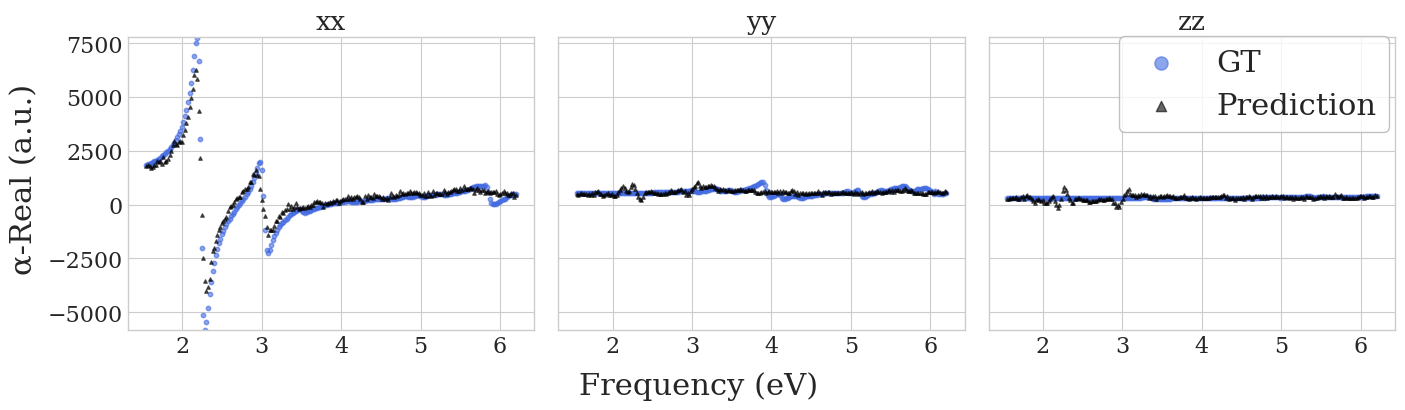

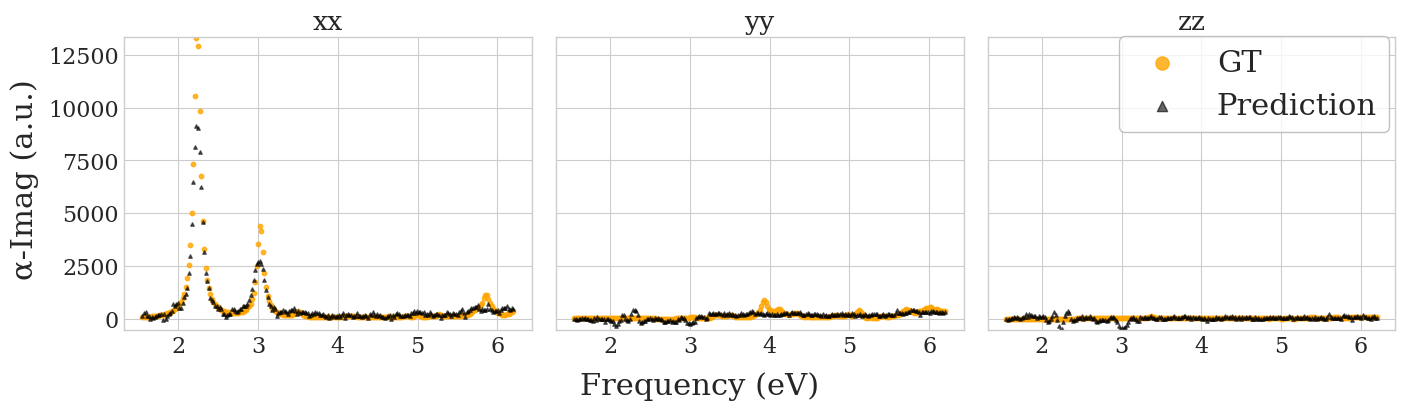

In [8]:
for i in range(1):
    data_entry = val_datasets[i]  # Assuming you want to plot the first entry
    plot_polarizability_elements(data_entry ,model, out_dir="../results", save_csv=True)

Flattened samples = 151830
Flattened samples predictions = 151830


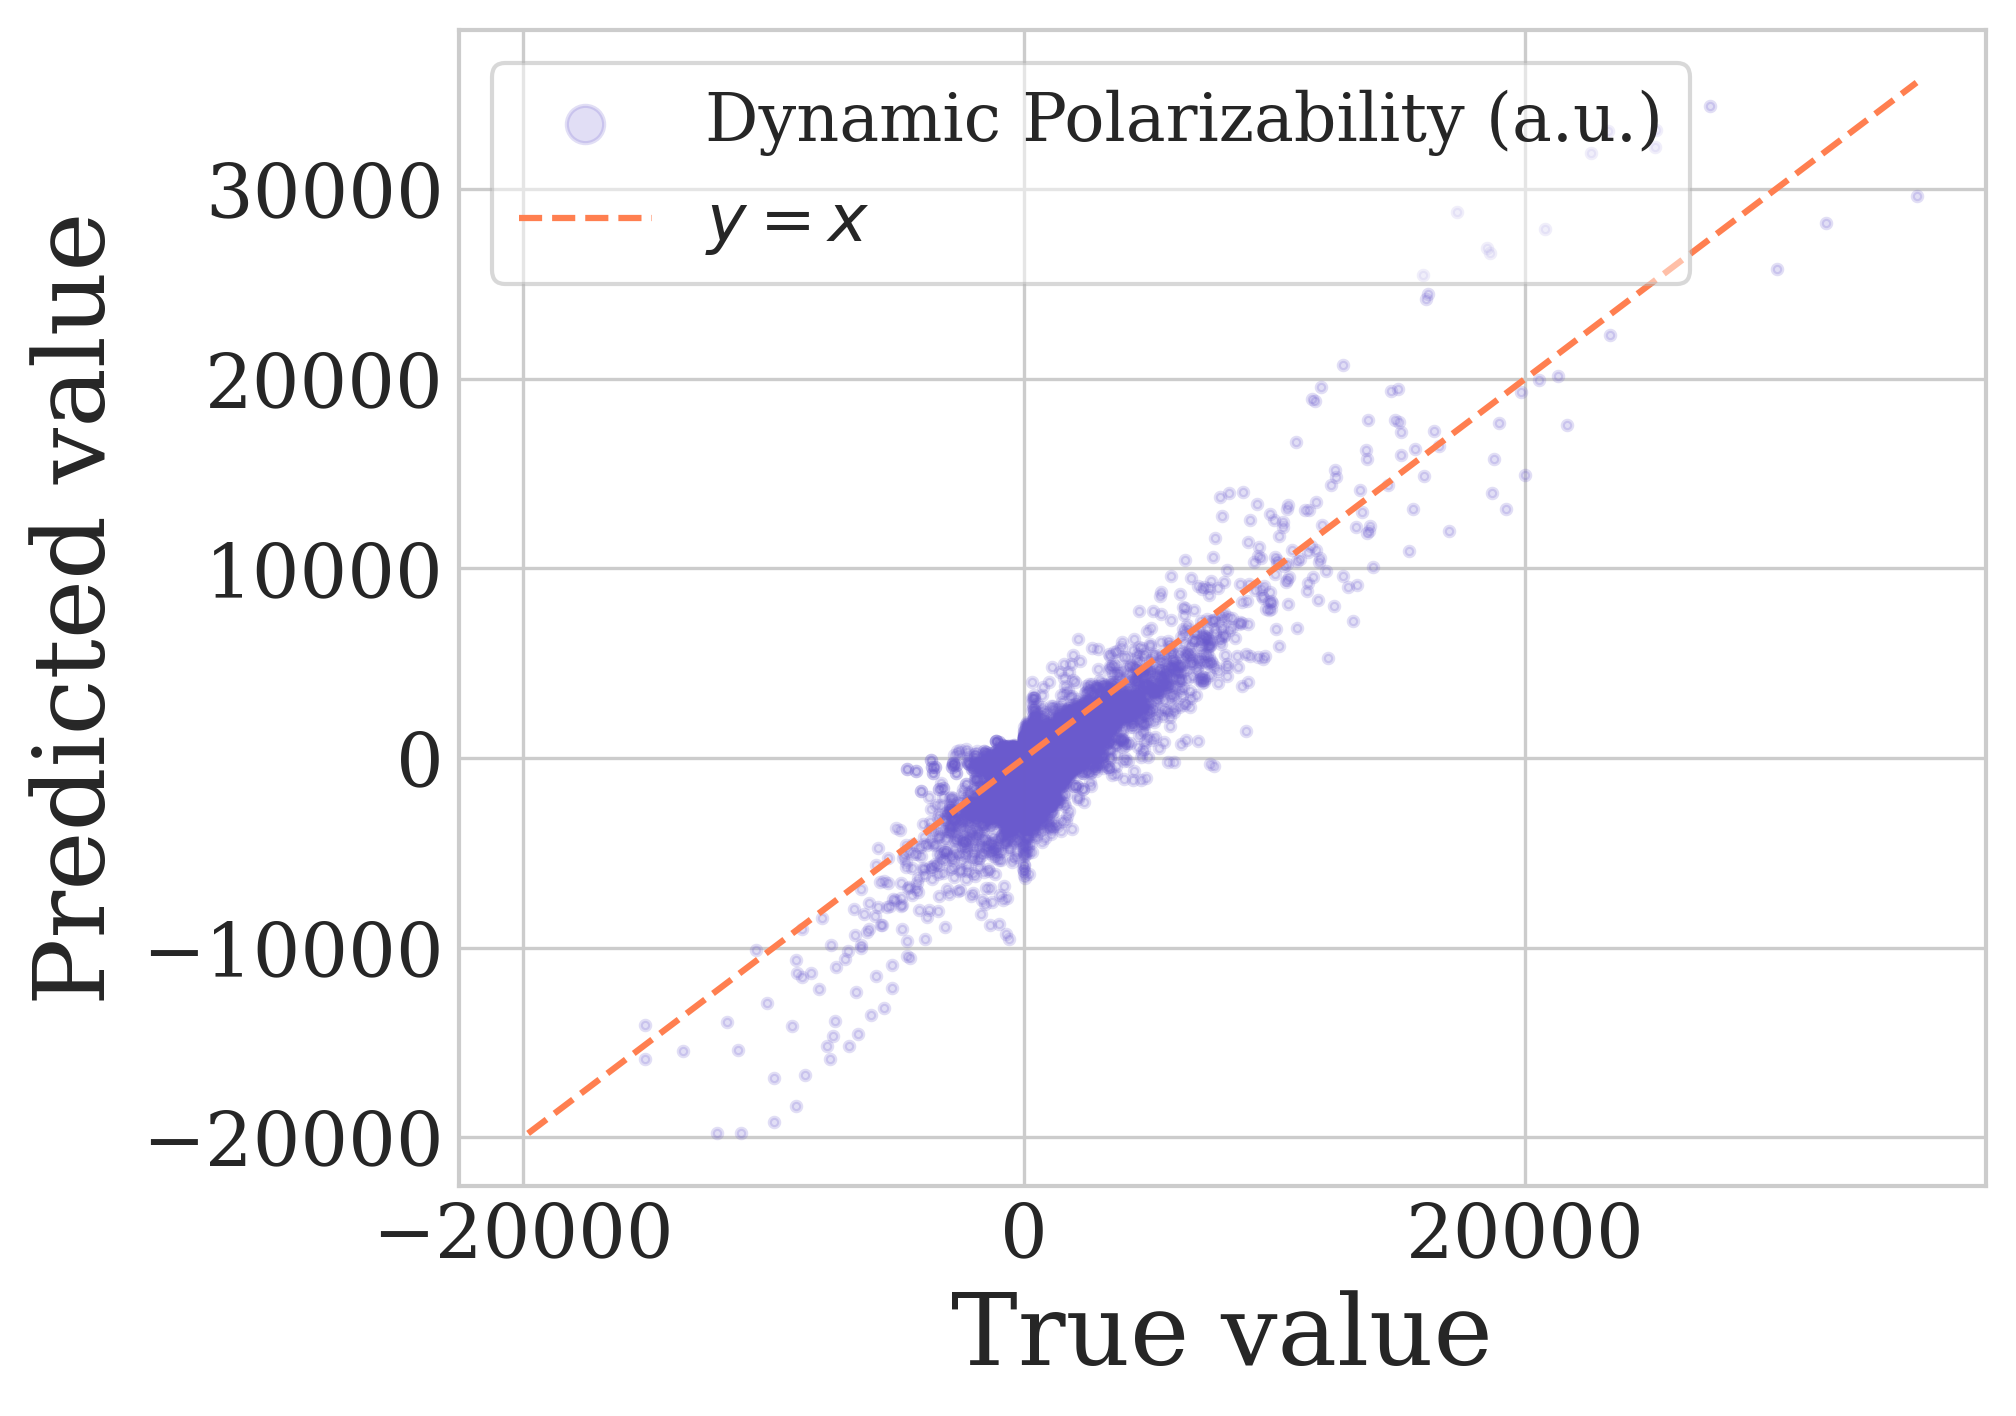

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from detanet_model import R2
from sklearn.metrics import r2_score, mean_absolute_error



# create a copy of the validation datasets
val_dataset_plot = [data.clone() for data in val_datasets]

for data_entry in val_dataset_plot:
    data_entry.real_ee = data_entry.real_ee[1:]  # remove static frequency
    data_entry.imag_ee = data_entry.imag_ee[1:]  # remove static frequency
    data_entry.y = torch.cat([data_entry.real_ee, data_entry.imag_ee], dim=0)  # [N, 6]


# 1. Validation DataLoader
val_loader = DataLoader(val_dataset_plot, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model   = model.to(device).eval()

true_vals, pred_vals = [], []

with torch.no_grad():
    for batch in val_loader:
        # a) ground-truth: flatten everything to 1-D
        true_vals.append(batch.y.cpu().view(-1))

        # b) prediction
        pred = model(
            z=batch.z.to(device),
            pos=batch.pos.to(device),
            x_features=batch.x.to(device)
        )

        # pred might already be numpy; make sure we flatten on CPU
        if isinstance(pred, torch.Tensor):
            pred_flat = pred.cpu().view(-1)
        else:
            pred_flat = torch.tensor(pred).view(-1)

        pred_vals.append(pred_flat)

# stack into single 1-D vectors
true_vals = torch.cat(true_vals).numpy()
pred_vals = torch.cat(pred_vals).numpy()

print("Flattened samples =", true_vals.size)   # total number of values
print("Flattened samples predictions =", pred_vals.size)   # total number of values




import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")  # 1) global style
plt.rcParams.update({                    # 2) fine-tune fonts
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size":        16,   # default text size
    "axes.labelsize":   24,   # x/y/z axis labels
    "axes.titlesize":   18,   # figure / axes titles
    "xtick.labelsize":  18,   # x-axis tick labels
    "ytick.labelsize":  18,   # y-axis tick labels
    "legend.fontsize":  16,   # legend text
})



# 2. Scatter plot
plt.figure(figsize=(7, 5),dpi=300)
plt.scatter(true_vals, pred_vals, c="slateblue", s=5, alpha=0.2, label="Dynamic Polarizability (a.u.)")

vmin, vmax = min(true_vals.min(), pred_vals.min()), max(true_vals.max(), pred_vals.max())
plt.plot([vmin, vmax], [vmin, vmax], "--", color="coral", label="$y=x$")

plt.xlabel("True value")
plt.ylabel("Predicted value")
#plt.title("Validation: Flattened Predicted vs. True")
plt.legend(
    frameon=True,
    facecolor="white",
    edgecolor="0.7",
    framealpha=0.5,
    markerscale=4.0
)

plt.grid(True)
plt.tight_layout()
plt.show()



import pandas as pd
import os

out_dir = "../results"               # or wherever you want it
os.makedirs(out_dir, exist_ok=True)

pd.DataFrame(
    {"true": true_vals, "pred": pred_vals}
).to_csv(
    os.path.join(out_dir, "HOPV241_dynamic_polarizability_pred_vs_true_scatter.csv"),
    index=False
)
